## This version uses the correct matrices in the linear equation. It however seems to give nearly indentical results to my previous version.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd

In [2]:
x = np.arange(-15, 16, 1)
y = x.copy()
y0, x0 = np.meshgrid(x, y)
grid = np.dstack((y0, x0))

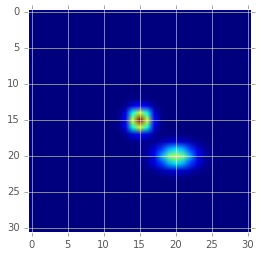

In [3]:
from scipy.stats import multivariate_normal

## see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html

def gaussian2d(grid, m=None, s=None):
    if m is None:
        m = [0., 0.]
    if s is None:
        s = [1., 1.]
    cov = [[s[0], 0], [0, s[1]]]
    var = multivariate_normal(mean=m, cov=cov)
    return var.pdf(grid)

#x, y = np.mgrid[-15:16:1, -15:16:1]
#grid = np.dstack((x, y))
g1 = gaussian2d(grid) + gaussian2d(grid, [5,5], [3,1])
plt.imshow(g1)

## Update: it looks like the actual code uses chebyshev1 polynomials!

Note these are essentially the same but with different scale factors.

In [4]:
# This code works, but I think the next cell is faster.
from numpy.polynomial.chebyshev import chebgrid2d

h0 = chebgrid2d(x, y, c=[[1, 0, 0], [1, 0, 0]])
h1 = chebgrid2d(x, y, c=[[0, 1, 0], [0, 1, 0]])
h2 = chebgrid2d(x, y, c=[[1, 0, 0], [0, 1, 0]])
h3 = chebgrid2d(x, y, c=[[0, 1, 0], [0, 0, 1]])

In [5]:
from numpy.polynomial.chebyshev import chebval2d
h0 = chebval2d(x0, y0, c=[[1, 0, 0], [1, 0, 0]])
h1 = chebval2d(x0, y0, c=[[0, 1, 0], [0, 1, 0]])
h2 = chebval2d(x0, y0, c=[[1, 0, 0], [0, 1, 0]])
h3 = chebval2d(x0, y0, c=[[0, 1, 0], [0, 0, 1]])

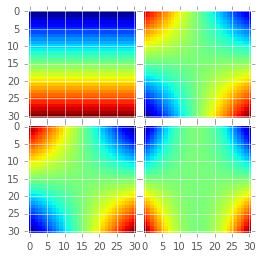

In [6]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(1, (4., 4.))
igrid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
igrid[0].imshow(h0, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[1].imshow(h1, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[2].imshow(h2, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[3].imshow(h3, interpolation='none')  # The AxesGrid object work as a list of axes.

In [7]:
## The following code does exactly the same as the above:
from numpy.polynomial.chebyshev import chebval
def chebval2d_try(x, y, xord, yord):
    cx = chebval(x, xord)
    cy = chebval(y, yord)
    h0 = np.outer(cx, cy)
    return h0

if False:
    #h0 = chebval2d_try(x, y, [1, 0, 0], [0, 1, 0])
    h0 = chebval2d_try(x, y, [0, 1, 0], [0, 1, 0])
    #h0 = chebval2d_try(x, y, [0, 1, 0], [0, 0, 1])
    print h0.shape
    plt.imshow(h0)

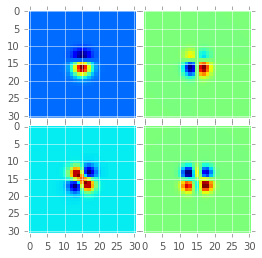

In [8]:
gh0 = gaussian2d(grid, s=[3., 3.]) * h0
gh1 = gaussian2d(grid, s=[3., 3.]) * h1
gh2 = gaussian2d(grid, s=[3., 3.]) * h2
gh3 = gaussian2d(grid, s=[3., 3.]) * h3
fig = plt.figure(1, (4., 4.))
igrid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
extent = (x0.min(), x0.max(), y0.min(), y0.max())
igrid[0].imshow(gh0, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[1].imshow(gh1, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[2].imshow(gh2, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[3].imshow(gh3, interpolation='none')  # The AxesGrid object work as a list of axes.

## Generate AL basis funcs now...

use same parameters as from the stack.

TBD: is a degGauss of 2 mean it goes up to order 2 (i.e. $x^2$)? Or is it 2 orders so it only goes up to linear ($x$)? Probably the former, so that's what we'll use.

In [9]:
# Parameters from stack
sigGauss = [0.75, 1.5, 3.0]
degGauss = [4, 2, 2]
betaGauss = 1   # in the Becker et al. paper sigGauss is 1 but PSF is more like 2 pixels?
# Parameters from and Becker et al. (2012)
#sigGauss = [0.75, 1.5, 3.0]
#degGauss = [6, 4, 2]

def chebGauss2d(x, y, grid, m=None, s=None, ord=[0,0], beta=1., verbose=False):
    if m is None:
        m = [0., 0.]
    if s is None:
        s = [1., 1.]
    cov = [[s[0], 0], [0, s[1]]]
    coefLen = np.max(ord)+1
    coef0 = np.zeros(coefLen)
    coef0[ord[0]] = 1
    coef1 = np.zeros(coefLen)
    coef1[ord[1]] = 1
    if verbose:
        print s, ord, coef0, coef1
    ga = gaussian2d(grid, m, np.array(s)/beta)
    ch = chebval2d(x, y, c=np.outer(coef0, coef1))
    return ch * ga

In [10]:
basis = [chebGauss2d(x0, y0, grid, m=[0,0], s=[sig0,sig1], ord=[deg0,deg1], beta=betaGauss, verbose=True) for i0,sig0 in enumerate(sigGauss) for i1,sig1 in enumerate(sigGauss) for deg0 in range(degGauss[i0]+1) for deg1 in range(degGauss[i1]+1)]
print len(basis), basis[0].shape, x0.shape, grid.shape, basis[0].reshape(x0.shape).shape

[0.75, 0.75] [0, 0] [ 1.] [ 1.]
[0.75, 0.75] [0, 1] [ 1.  0.] [ 0.  1.]
[0.75, 0.75] [0, 2] [ 1.  0.  0.] [ 0.  0.  1.]
[0.75, 0.75] [0, 3] [ 1.  0.  0.  0.] [ 0.  0.  0.  1.]
[0.75, 0.75] [0, 4] [ 1.  0.  0.  0.  0.] [ 0.  0.  0.  0.  1.]
[0.75, 0.75] [1, 0] [ 0.  1.] [ 1.  0.]
[0.75, 0.75] [1, 1] [ 0.  1.] [ 0.  1.]
[0.75, 0.75] [1, 2] [ 0.  1.  0.] [ 0.  0.  1.]
[0.75, 0.75] [1, 3] [ 0.  1.  0.  0.] [ 0.  0.  0.  1.]
[0.75, 0.75] [1, 4] [ 0.  1.  0.  0.  0.] [ 0.  0.  0.  0.  1.]
[0.75, 0.75] [2, 0] [ 0.  0.  1.] [ 1.  0.  0.]
[0.75, 0.75] [2, 1] [ 0.  0.  1.] [ 0.  1.  0.]
[0.75, 0.75] [2, 2] [ 0.  0.  1.] [ 0.  0.  1.]
[0.75, 0.75] [2, 3] [ 0.  0.  1.  0.] [ 0.  0.  0.  1.]
[0.75, 0.75] [2, 4] [ 0.  0.  1.  0.  0.] [ 0.  0.  0.  0.  1.]
[0.75, 0.75] [3, 0] [ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[0.75, 0.75] [3, 1] [ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[0.75, 0.75] [3, 2] [ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[0.75, 0.75] [3, 3] [ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[0.75, 0.75] [3, 4] [ 0.

In [11]:
print len(basis), basis[0].shape, basis[0].reshape(x0.shape).shape, 31*31
basis2 = np.dstack(basis).T  # put the bases into an array
print basis2.shape, basis2[0].shape, basis2[0].reshape(x0.shape).shape
print basis[0].min(), basis[0].max(), basis2.min(), basis2.max()

121 (31, 31) (31, 31) 961
(121, 31, 31) (31, 31) (31, 31)
1.0924820179e-131 0.212206590789 -14.1624248714 14.1624248714


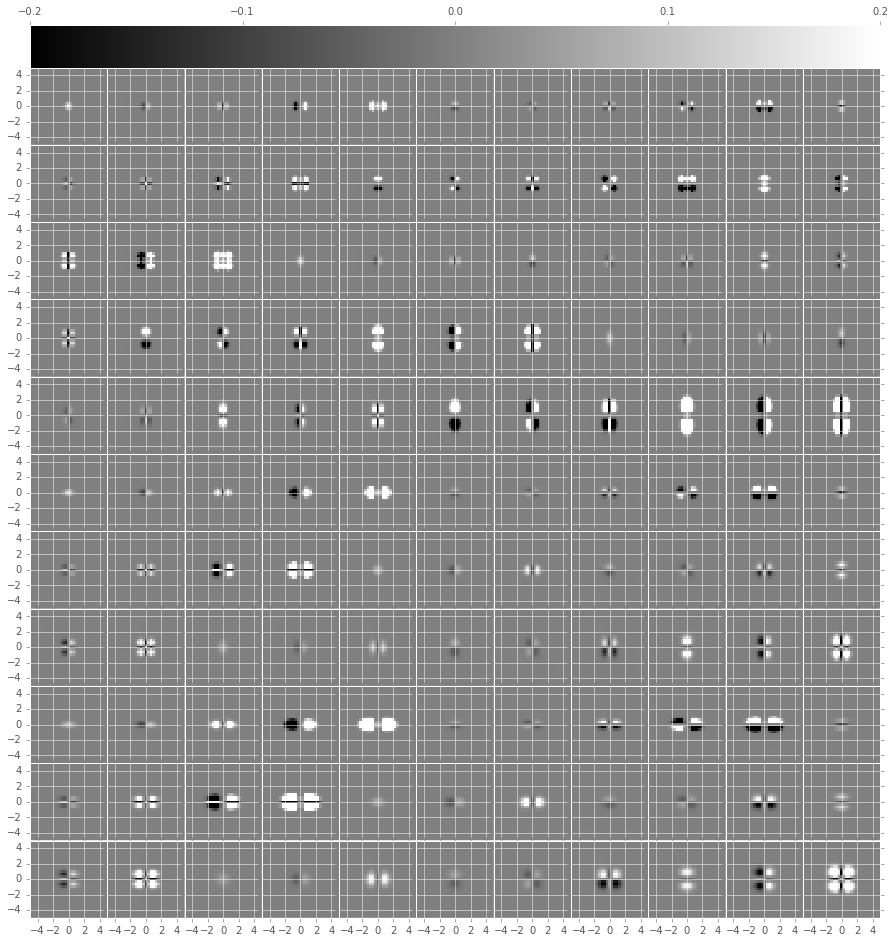

In [12]:
limits = [-0.2, 0.2] #[basis2.min(), basis2.max()]
fig = plt.figure(1, (16., 16.))
igrid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(11, 11),  # creates 2x2 grid of axes
                    axes_pad=0.0,
                    share_all=True,
                    label_mode="L",
                    cbar_location="top",
                    cbar_mode="single"
                 )
extent = (x0.min()+10, x0.max()-10, y0.min()+10, y0.max()-10)
for i in range(121):
    gim = igrid[i].imshow(basis[i].reshape(x0.shape), origin='lower', interpolation='none', cmap='gray', extent=extent,
                         vmin=limits[0], vmax=limits[1])
igrid.cbar_axes[0].colorbar(gim)

Make the two "images". `im1` is the template, `im2` is the science image.

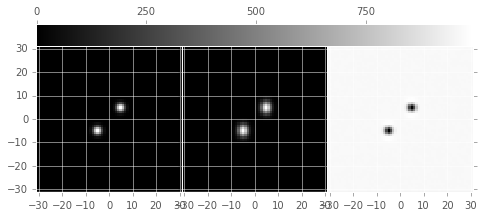

In [82]:
xim = np.arange(-31, 32, 1)
yim = xim.copy()
y0im, x0im = np.meshgrid(xim, yim)
imgrid = np.dstack((y0im, x0im))

psf1 = 1.6 # sigma in pixels im1 will be template
psf2 = 2.2 # sigma in pixels im2 will be science image
im1 = 10000 * (gaussian2d(imgrid, m=[-5,-5], s=[psf1, psf1]) + gaussian2d(imgrid, m=[5,5], s=[psf1, psf1]))
im2 = 5000  * (gaussian2d(imgrid, m=[-5,-5], s=[psf2, psf2*1.5]) + gaussian2d(imgrid, m=[5,5], s=[psf2, psf2*1.5]))
sig1 = 0.2  # sigma of template
sig2 = 0.2  # sigma of science image
im1 += np.random.normal(scale=sig1, size=im1.shape)
im2 += np.random.normal(scale=sig2, size=im2.shape)

fig = plt.figure(1, (9, 3))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 3), axes_pad=0.0, share_all=True, label_mode="L",
                    cbar_location="top", cbar_mode="single")
extent = (x0im.min(), x0im.max(), y0im.min(), y0im.max())
gim = igrid[0].imshow(im1, origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[1].imshow(im2, origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[2].imshow(im2-im1, origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid.cbar_axes[0].colorbar(gim)

Convolve im1 (tenmplate) with the basis functions, and make these the *new* bases.

In [83]:
import scipy.signal

basis2 = [scipy.signal.fftconvolve(im1, b, mode='same') for b in basis]
print len(basis2), basis2[0].shape

basis2a = np.vstack([b.flatten() for b in basis2]).T
print basis2a.shape, im2.flatten().shape

121 (63, 63)
(3969, 121) (3969,)


Do the linear fit to compute the matching kernel. The resulting fit is the convolved diffim.

[ -2.63678537e+03   1.47576451e+03  -3.16831491e+03   1.24109482e-01
   1.28433946e+01  -1.45564852e+04  -6.03544071e+00  -1.45960062e+03
  -5.48784848e-02  -3.31304404e+01   1.42311988e+03   1.53586223e+02
  -1.50692828e+02   1.40828094e-01   4.87319400e+00   2.04966920e-01
  -4.36920185e-01  -5.22225398e-01   3.01556745e-03  -2.56260042e-03
   7.27928701e+00   3.62863298e+00  -5.56782642e+00   3.82273820e-03
   5.82266682e-02   4.03597438e+03  -1.83320205e+03   4.39691665e+03
   9.27853855e+00   5.33443661e+00   7.35781961e+00  -1.05441381e+03
   1.07503377e+02  -3.05248385e+02   8.93820559e-02  -2.01458141e-01
  -2.42145856e-01  -3.41711066e+00  -1.14209530e+00   2.60837377e+00
   7.66494117e+03   9.20972709e+01   8.68562136e+01  -3.64481730e+00
   1.16809544e+00   1.09222120e+00  -1.27683676e+02  -1.10986093e+00
   9.45725951e-01   3.03820450e-03  -8.12142088e-03  -7.62103115e-03
   3.29285030e-02   1.00402182e-03  -3.28163993e-02   1.68762755e+03
  -2.20247179e+00  -7.82304075e+02

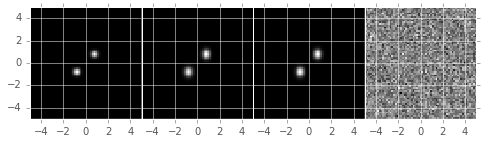

In [84]:
pars, resid, _, _ = np.linalg.lstsq(basis2a, im2.flatten())
print pars
fit = (pars * basis2a).sum(1).reshape(im2.shape)
print resid, np.sum((im2 - fit.reshape(im2.shape))**2), np.sum((im2 - im1)**2)
print basis2a.shape, fit.shape

fig = plt.figure(1, (8, 2))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.0)
extent = (x0.min()+10, x0.max()-10, y0.min()+10, y0.max()-10)
gim = igrid[0].imshow(im1, origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[1].imshow(fit, origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[2].imshow(im2, origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[3].imshow(im2 - fit, origin='lower', interpolation='none', cmap='gray', extent=extent)
#igrid.cbar_axes[0].colorbar(gim)
print scipy.stats.describe(im2 - fit, axis=None)

Look at the resulting matching kernel by multiplying the fitted parameters times the original basis funcs. and test that actually convolving it with the template gives us a good subtraction.

(121,) (961, 121)
0.500519812457


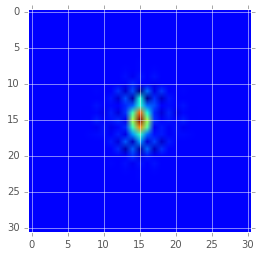

In [85]:
kbasis = np.vstack([b.flatten() for b in basis]).T
print pars.shape, kbasis.shape
kfit = (pars * kbasis).sum(1).reshape(basis[0].shape)
print kfit.sum()
#kfit /= kfit.sum()
plt.imshow(kfit)  # this plots the matching kernel

Compare the convolved template to the science image. Also plot the new diffim for comparison.

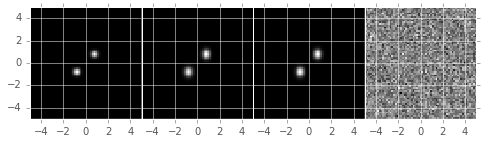

In [86]:
conv_im1 = scipy.ndimage.filters.convolve(im1, kfit, mode='constant')
fig = plt.figure(1, (8, 2))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.0)
extent = (x0.min()+10, x0.max()-10, y0.min()+10, y0.max()-10)
gim = igrid[0].imshow(im1, origin='lower', interpolation='none', cmap='gray', extent=extent) # original template (red)
igrid[1].imshow(conv_im1, origin='lower', interpolation='none', cmap='gray', extent=extent) # convolved template (blue)
igrid[2].imshow(im2, origin='lower', interpolation='none', cmap='gray', extent=extent) # science image (dotted, purple)
igrid[3].imshow(im2 - conv_im1, origin='lower', interpolation='none', cmap='gray', extent=extent) # diffim (grey)

Create the $b_i$ and $M_{ij}$ from the A&L (1998) and Becker (2012) papers. This was done wrong in the previous version of notebook 3 (and above), although it gives identical results.

(121,)
(121, 121)
[ -4.83892943e+00  -1.35398876e+01  -2.01732441e+00   1.71750422e-01
  -1.66907613e-01  -2.41623125e+00  -9.22331382e+00  -9.82783673e+00
   9.41026327e-02  -4.19828602e-02   7.05334994e+00  -1.04340431e+00
   1.66106783e+00   4.35791588e-02  -2.10449029e-01   2.83728710e-01
  -8.29730115e-01  -7.03080599e-01   2.76497860e-03  -3.26009453e-03
   1.06159617e-01  -7.26600725e-02   3.04501424e-01   2.87325075e-03
  -1.26315811e-03  -6.21276739e+00   1.18453652e+01   1.01129932e+00
  -2.03379957e+00   1.02198308e+01   8.54000590e+00  -7.62565770e+01
  -1.11396306e+00  -1.01020308e+01   1.26377350e-01  -3.83817354e-01
  -3.31676419e-01   3.48894758e-03   1.10013917e-03  -1.31840632e-02
  -5.67047418e+00   9.01395980e+00  -2.42406598e+00  -1.64340081e+00
   2.17291734e+00   1.84672215e+00   1.64351307e+01  -2.98284196e-01
   2.48418313e+00   4.53358680e-03  -1.48910340e-02  -1.11534070e-02
  -4.98073705e-04   1.15742990e-03  -6.25388391e-03   4.65342095e+00
  -1.67598167e+0

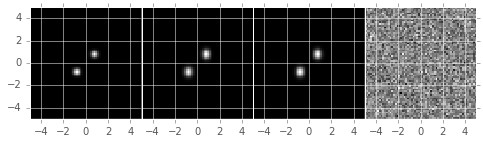

In [87]:
b = (basis2a.T * im2.flatten()).sum(1)
print b.shape

M = np.dot(basis2a.T, basis2a)
print M.shape

pars2, resid, _, _ = np.linalg.lstsq(M, b)
print pars2
#print 'Difference (log10):\n', np.log10(np.abs((pars2-pars)/pars2))

fit2 = (pars2 * basis2a).sum(1).reshape(im1.shape)
print basis2a.shape, fit2.shape

fig = plt.figure(1, (8, 2))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.0)
extent = (x0.min()+10, x0.max()-10, y0.min()+10, y0.max()-10)
gim = igrid[0].imshow(im1, origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[1].imshow(fit2, origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[2].imshow(im2, origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[3].imshow(im2 - fit2, origin='lower', interpolation='none', cmap='gray', extent=extent)
#igrid.cbar_axes[0].colorbar(gim)
print scipy.stats.describe(im2 - fit2, axis=None)
#print pars2-pars

(121,) (961, 121)
0.500412581405


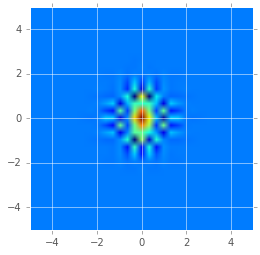

In [88]:
kbasis = np.vstack([b.flatten() for b in basis]).T
print pars2.shape, kbasis.shape
kfit2 = (pars2 * kbasis).sum(1).reshape(basis[0].shape)
print kfit2.sum()
#kfit2 /= kfit2.sum()
extent = (x0.min()+10, x0.max()-10, y0.min()+10, y0.max()-10)
plt.imshow(kfit2, extent=extent)  # this plots the matching kernel

(63, 63) -0.216647904773 295.34080219
DescribeResult(nobs=3969, minmax=(2.327429615504578e-08, 489184.60674751748), mean=1019.7537908237059, variance=255020478.13359168, skewness=21.271717667844133, kurtosis=532.2932197754346)
DescribeResult(nobs=3969, minmax=(2.3403342499979796e-08, 0.58656175175003999), mean=0.040869316548123501, variance=0.0032887379584791753, skewness=2.8268240933201207, kurtosis=11.91246290939068)


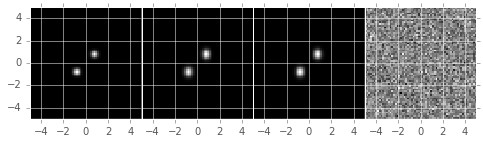

In [89]:
conv_im1 = scipy.ndimage.filters.convolve(im1, kfit2, mode='constant')
print conv_im1.shape, conv_im1.min(), conv_im1.max()
print scipy.stats.describe((im2 - im1)**2, axis=None)
print scipy.stats.describe((im2 - conv_im1)**2, axis=None)

fig = plt.figure(1, (8, 2))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.0)
extent = (x0.min()+10, x0.max()-10, y0.min()+10, y0.max()-10)
gim = igrid[0].imshow(im1, origin='lower', interpolation='none', cmap='gray', extent=extent) # original template (red)
igrid[1].imshow(conv_im1, origin='lower', interpolation='none', cmap='gray', extent=extent) # convolved template (blue)
igrid[2].imshow(im2, origin='lower', interpolation='none', cmap='gray', extent=extent) # science image (dotted, purple)
igrid[3].imshow(im2 - conv_im1, origin='lower', interpolation='none', cmap='gray', extent=extent) # diffim (grey)

Add taking into account PSF variations... (next notebook, #4)